# NLP.F2501 Course Project 1 (Word embeddings and RNNs)

Nevin Helfenstein

# Introduction

In this notebook, I present my solution to the CommonsenseQA task. I'll train a model using word embeddings, RNNs, and other NLP techniques to achieve the best possible performance.

## Dataset Description

The CommonsenseQA dataset [(Talmor et al., 2019)](https://aclanthology.org/N19-1421/) contains 12,247 multiple-choice questions specifically designed to test commonsense reasoning. Unlike standard QA tasks, these questions require prior knowledge about how concepts relate in the real world.

Questions were created by extracting related concepts from ConceptNet and having crowd-workers author questions that require distinguishing between them. This methodology produced challenging questions that often cannot be answered through simple pattern matching.

The best baseline in the original paper (BERT-large) achieved only 56% accuracy compared to human performance of 89%, shwoing the difficulty of encoding human-like commonsense reasoning.

# Setup

First we import all the needed libraries

In [1]:
import torch
import nltk
import wandb
import logging
import re

import gensim

import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from matplotlib_venn import venn2


from datasets import load_dataset
from huggingface_hub import hf_hub_download

from collections import Counter
from datetime import datetime


/home/nevin/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### WandDB

We set up the configuration to W&B for later use

In [ ]:
#TODO: Correct configuration for the new wanddb project

wandb.login(key="")
wandb_logger = WandbLogger(project="experiment-tracking")

def init_wandb_run(project_name, run_name, config_dict):
    run = wandb.init(
        project=project_name,
        name=run_name,
        config=config_dict,
    )
    return run


#### Example Run
experiment_1_config = {
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32,
    "optimizer": "adam"
}
run1 = init_wandb_run("experiment-tracking", "experiment_1", experiment_1_config)


### Fixed variables

We set the random seed for all the necessary configurations  to ensure reproducibility

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Tokenizer and embedding model

I've selected FastText embeddings with the common crawl model (crawl-3dd-2m-subword) for this project for the following reasons:

* **Subword modeling** - handles unknown words & typos
* **Morphologically aware** - recognizes word relationships 
* **Massive training corpus** - 600B tokens from Common Crawl
* **Rich embeddings** - 300 dimensions, 2M word vectors
* **Proven performance** - excels in commonsense reasoning tasks
* **Well Documented** - is known in the NLP community and is very well documented

Download tokenizer files

In [3]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /home/nevin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Download the FastText model from Hugging Face (Facebook's common crawl model)

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

Load the model

In [5]:
ft_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = ft_model.wv

Create a function to get embeddings for words (retruns word vector)

In [6]:
def get_fasttext_embedding(word):
    try:
        return ft_model[word]
    except KeyError:
        return np.zeros(300)

### Data Splits

The data is available on Hugging Face: [Data](https://huggingface.co/datasets/tau/commonsense_qa).
Only the train and validation splits have an answer key, because of that we will use our own dataset splits.
We use all of the datasamples as the train set except for the last 1000 which we set as the validation set. The original validation set is set as the test set.

In [7]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data exploration

We convert to DataFrames for easier analysis

In [8]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)
test_df = pd.DataFrame(test)

datasets = {
    "Training": train_df,
    "Validation": valid_df,
    "Test": test_df
}

We check basic statistics such as average question and choice lenght for each DataFrame

In [9]:
def analyze_dataset(df, name):
    """Analyze basic statistics of a dataset split without modifying the dataframe"""
    print(f"=== {name} Set Statistics ===")
    print(f"Number of examples: {len(df)}")
    
    # Question length statistics
    question_lengths = [len(word_tokenize(q)) for q in df['question']]
    
    # Let's examine the structure of the first row's choices
    print(f"Example 'choices' structure: {df['choices'].iloc[0]}")
    
    # Based on the structure, we'll compute choice lengths
    choice_lengths = []
    for choices_row in df['choices']:
        # Modify this part based on the actual structure of 'choices'
        if isinstance(choices_row, list):
            # If 'choices' contains dictionaries with 'text' field
            try:
                row_lengths = [len(word_tokenize(choice['text'])) for choice in choices_row]
            except TypeError:
                # If 'choices' is a list of strings
                row_lengths = [len(word_tokenize(choice)) for choice in choices_row]
        elif isinstance(choices_row, str):
            # If 'choices' is just a string
            row_lengths = [len(word_tokenize(choices_row))]
        else:
            row_lengths = [0]  # Fallback
        
        choice_lengths.append(row_lengths)
    
    avg_choice_lengths = [np.mean(lengths) if lengths else 0 for lengths in choice_lengths]
    
    # Print statistics
    print(f"Average question length: {np.mean(question_lengths):.2f} tokens")
    print(f"Average answer choice length: {np.mean(avg_choice_lengths):.2f} tokens")
    print(f"Min/Max question length: {min(question_lengths)}/{max(question_lengths)} tokens")
    
    # Correct answer positions (conditional on 'answerKey' existence)
    if 'answerKey' in df.columns:
        correct_positions = []
        for _, row in df.iterrows():
            try:
                correct_idx = next((i for i, choice in enumerate(row['choices']) 
                                if choice['label'] == row['answerKey']), -1)
            except (TypeError, KeyError):
                correct_idx = -1
            correct_positions.append(correct_idx)
        
        valid_positions = [p for p in correct_positions if p >= 0]
        if valid_positions:
            position_counts = np.bincount(valid_positions)
            print(f"Distribution of correct answers: {position_counts}")
    
    return df

# Run analysis
train_df = analyze_dataset(train_df, "Training")
valid_df = analyze_dataset(valid_df, "Validation")
test_df = analyze_dataset(test_df, "Test")

=== Training Set Statistics ===
Number of examples: 8741
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
Average question length: 14.90 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/67 tokens
=== Validation Set Statistics ===
Number of examples: 1000
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['eat cake', 'getting drunk', 'having sex', 'cleaning rooms', 'drink too much']}
Average question length: 15.03 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 5/48 tokens
=== Test Set Statistics ===
Number of examples: 1221
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']}
Average question length: 14.73 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/60 tokens


We plot the question lenght distribution

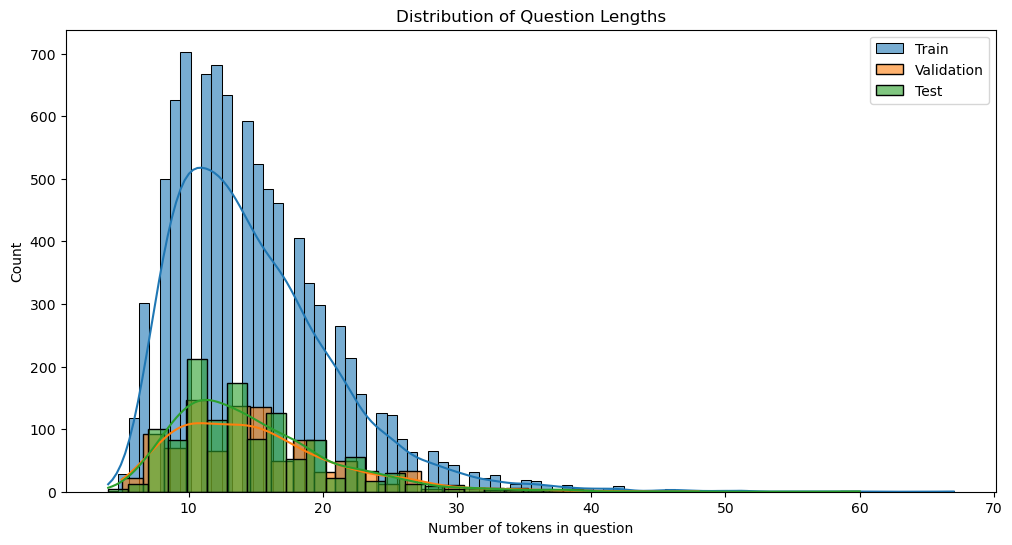

In [10]:
train_df['question_length'] = train_df['question'].apply(lambda x: len(word_tokenize(x)))
valid_df['question_length'] = valid_df['question'].apply(lambda x: len(word_tokenize(x)))
test_df['question_length'] = test_df['question'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='question_length', kde=True, label='Train', alpha=0.6)
sns.histplot(data=valid_df, x='question_length', kde=True, label='Validation', alpha=0.6)
sns.histplot(data=test_df, x='question_length', kde=True, label='Test', alpha=0.6)

plt.title('Distribution of Question Lengths')
plt.xlabel('Number of tokens in question')
plt.ylabel('Count')
plt.legend()
plt.savefig('viz/question_length_distribution.png')
plt.show()
plt.close()

We plot the answer key distribution

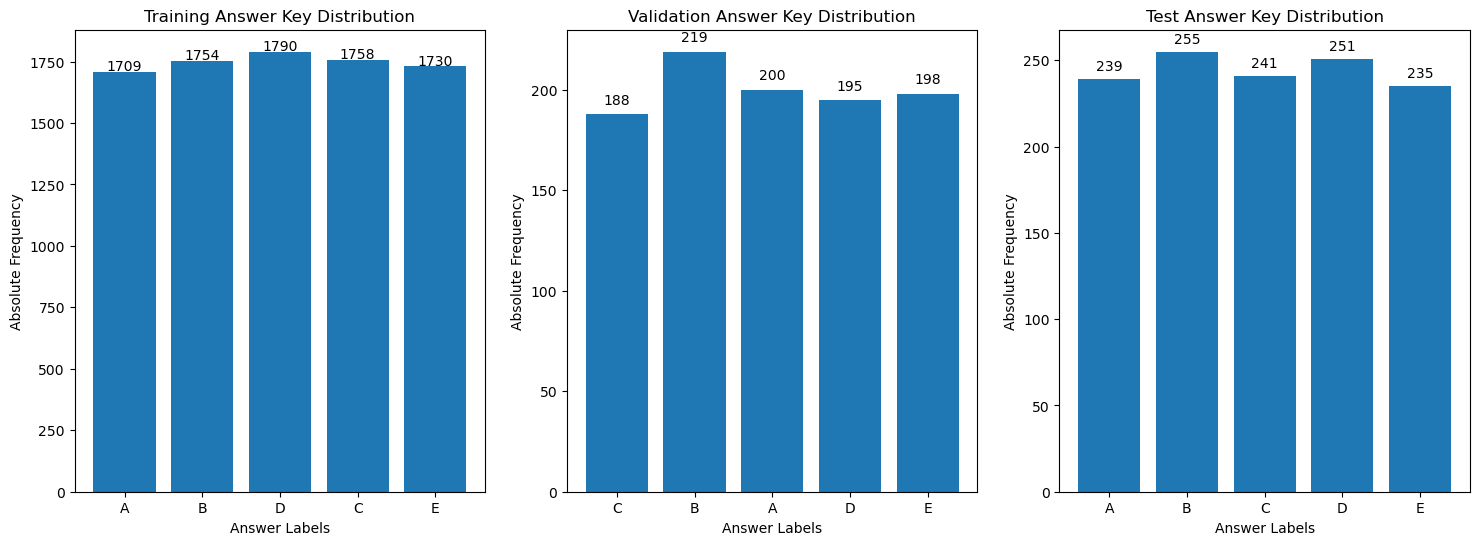

In [11]:
plt.figure(figsize=(18, 6))

for i, (split, df) in enumerate(datasets.items(), 1):
    # Count occurrences of each answer key
    answer_counts = Counter(df['answerKey'])
    
    # Create subplot
    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")
    
    # Add count labels on top of each bar
    for label, count in answer_counts.items():
        plt.text(label, count + 5, str(count), ha='center')

plt.savefig('viz/answer_key_distribution.png')
plt.show()  # Optional: display the plot in addition to saving it

Analyze question types (what, how, why, etc.)

In [15]:
def get_question_type(question):
    # Convert to lowercase to make matching case-insensitive
    question_lower = question.lower().strip()
    
    # Define patterns to match different question types
    if question_lower.startswith('how '):
        return 'how'
    elif question_lower.startswith('what '):
        return 'what'
    elif question_lower.startswith('when '):
        return 'when'
    elif question_lower.startswith('where '):
        return 'where'
    elif question_lower.startswith('which '):
        return 'which'
    elif question_lower.startswith('who '):
        return 'who'
    elif question_lower.startswith('why '):
        return 'why'
    else:
        return 'other'

In [16]:
# Apply the function to create the 'question_type' column
for split, df in datasets.items():
    # Find the column containing questions - could be 'question', 'text', etc.
    # Print columns to help identify which one contains the questions
    print(f"Columns in {split} dataset:", df.columns.tolist())
    
    # Assuming 'question' is the column name - replace with the actual column name if different
    question_column = 'question'  # Update this if your column name is different
    
    if question_column in df.columns:
        # Create question_type column
        df['question_type'] = df[question_column].apply(get_question_type)
    else:
        print(f"No 'question' column found in {split} dataset. Available columns: {df.columns.tolist()}")

Columns in Training dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length']
Columns in Validation dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length']
Columns in Test dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length']


Columns in Training dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']
Columns in Validation dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']
Columns in Test dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']


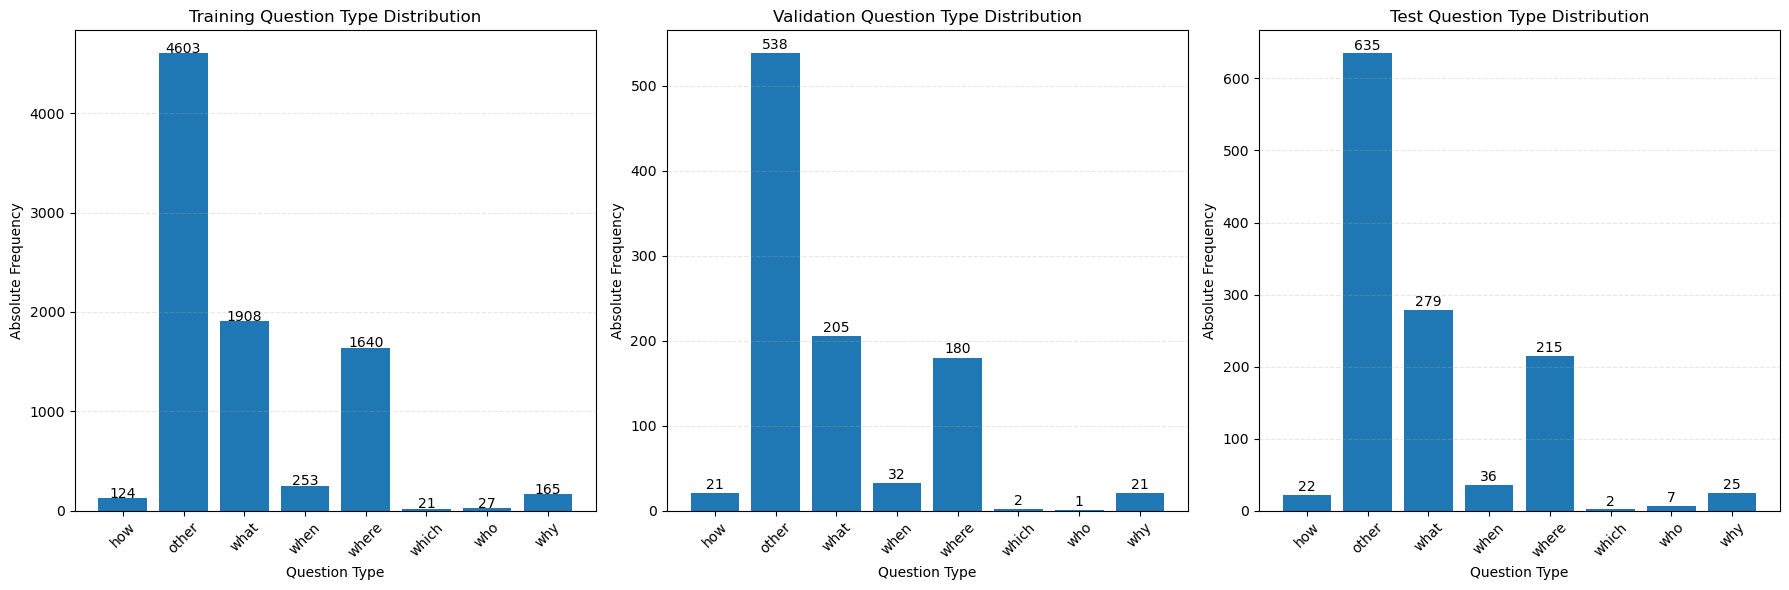

In [17]:
plt.figure(figsize=(18, 6))

for split, df in datasets.items():
    print(f"Columns in {split} dataset:", df.columns.tolist())

for i, (split, df) in enumerate(datasets.items(), 1):
    # Count occurrences of each question type
    question_type_counts = Counter(df['question_type'])
    
    # Sort the question types for consistency
    sorted_types = sorted(question_type_counts.keys())
    sorted_counts = [question_type_counts[t] for t in sorted_types]
    
    # Create subplot
    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_counts)
    plt.xlabel("Question Type")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Question Type Distribution")
    
    # Add count labels on top of each bar
    for j, (q_type, count) in enumerate(zip(sorted_types, sorted_counts)):
        plt.text(j, count + 5, str(count), ha='center')
    
    # Add grid for readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Rotate x-labels if needed
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('viz/question_type_distribution.png', dpi=300)
plt.show()

Count question types and convert it to percentage

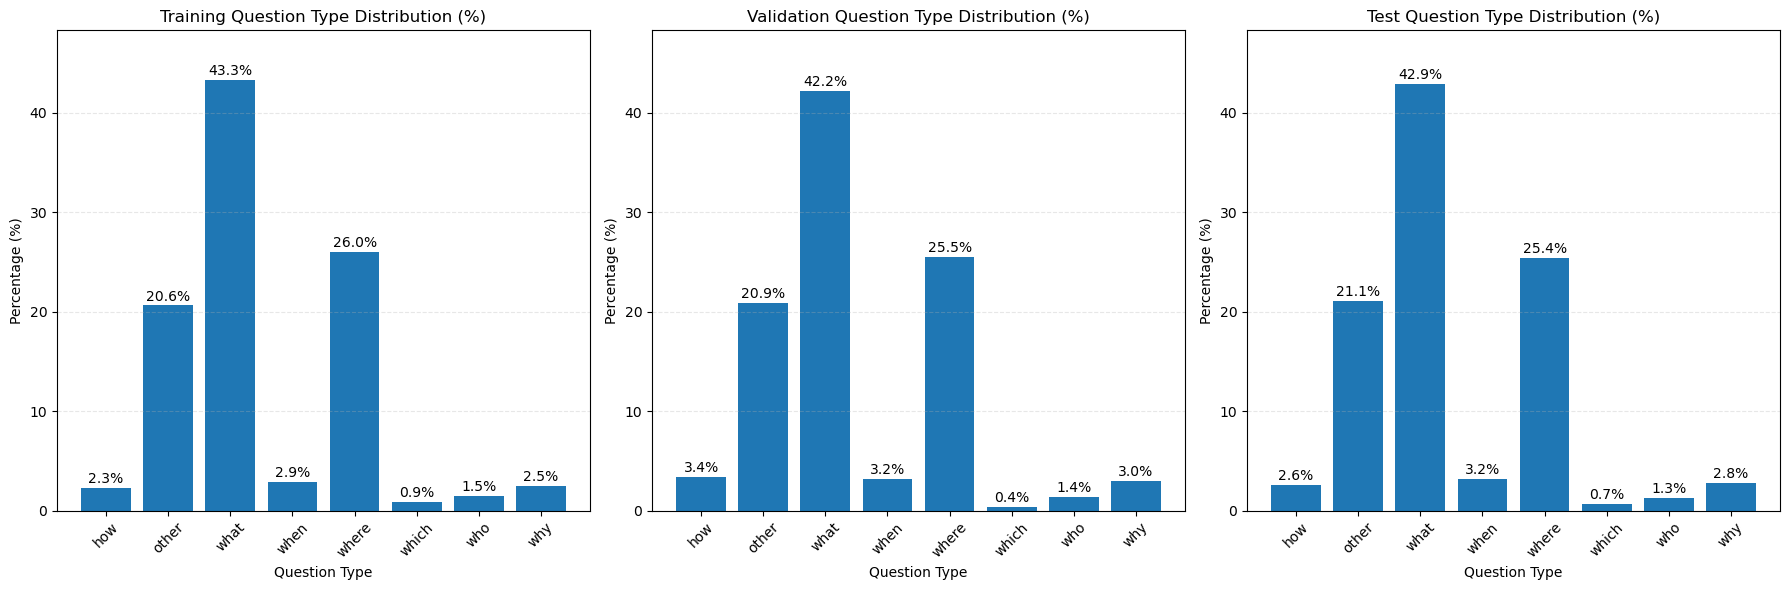

In [45]:
plt.figure(figsize=(18, 6))

# Calculate percentages for each dataset
train_type_counts = Counter(train_df['question_type'])
valid_type_counts = Counter(valid_df['question_type'])
test_type_counts = Counter(test_df['question_type'])

train_type_percent = {k: v/len(train_df)*100 for k, v in train_type_counts.items()}
valid_type_percent = {k: v/len(valid_df)*100 for k, v in valid_type_counts.items()}
test_type_percent = {k: v/len(test_df)*100 for k, v in test_type_counts.items()}

# Create a dictionary mapping your dataset names to the percentage dictionaries
datasets = {
    "Training": train_type_percent,
    "Validation": valid_type_percent,
    "Test": test_type_percent
}

# Plot for each dataset
for i, (split, percent_dict) in enumerate(datasets.items(), 1):
    # Sort the question types for consistency
    sorted_types = sorted(percent_dict.keys())
    sorted_percents = [percent_dict[t] for t in sorted_types]
    
    # Create subplot
    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_percents)
    plt.xlabel("Question Type")
    plt.ylabel("Percentage (%)")
    plt.title(f"{split} Question Type Distribution (%)")
    
    # Add percentage labels on top of each bar
    for j, (q_type, percent) in enumerate(zip(sorted_types, sorted_percents)):
        plt.text(j, percent + 0.5, f"{percent:.1f}%", ha='center')
    
    # Add grid for readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Rotate x-labels
    plt.xticks(rotation=45)
    
    # Set y-axis limit to make comparison easier
    plt.ylim(0, max(max(train_type_percent.values()), 
                   max(valid_type_percent.values()),
                   max(test_type_percent.values())) + 5)

plt.tight_layout()
plt.savefig('question_type_percentage_distribution.png', dpi=300)
plt.show()

POS (Part-of-Speach) Tag analysis for questions

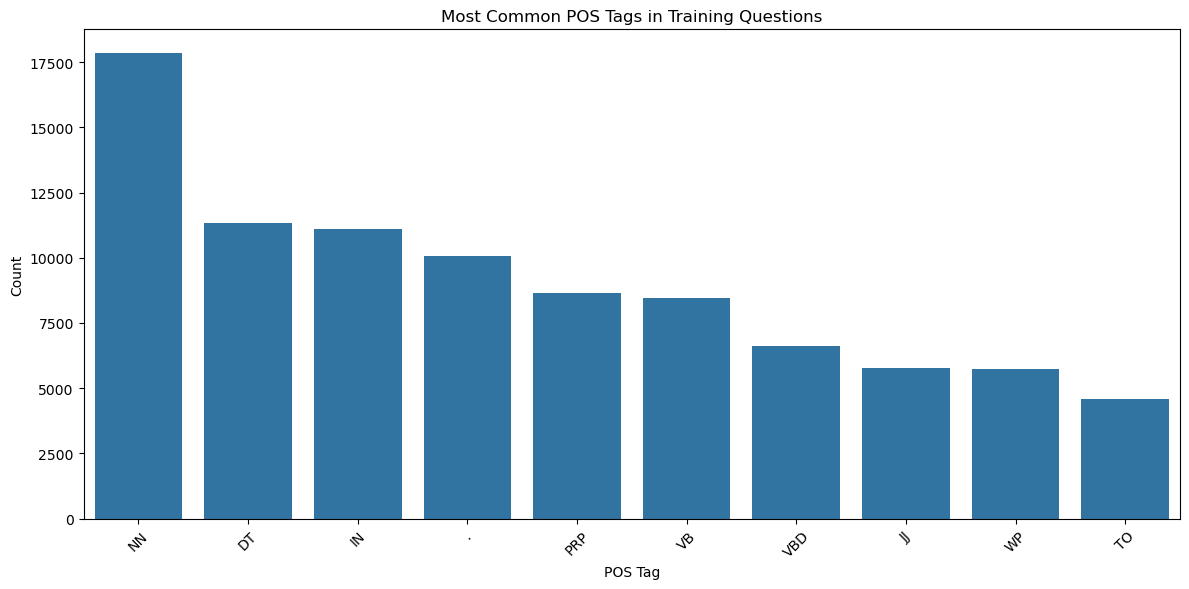

In [47]:
def analyze_pos_tags(texts, n=10):
    """Analyze the most common POS tags in a list of texts"""
    all_pos = []
    for text in texts:
        tokens = word_tokenize(text)
        tags = pos_tag(tokens)
        all_pos.extend([tag for _, tag in tags])
    
    return Counter(all_pos).most_common(n)

# Get most common POS tags in train questions
train_pos = analyze_pos_tags(train_df['question'].tolist())

plt.figure(figsize=(12, 6))
pos_df = pd.DataFrame(train_pos, columns=['POS Tag', 'Count'])
sns.barplot(x='POS Tag', y='Count', data=pos_df)
plt.title('Most Common POS Tags in Training Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pos_tag_distribution.png')
plt.show()
plt.close()

Analyze vocabulary overlap between train and test

In [48]:
def get_vocab(texts):
    """Get vocabulary from a list of texts"""
    vocab = set()
    for text in texts:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
    return vocab

train_vocab = get_vocab(train_df['question'].tolist())
test_vocab = get_vocab(test_df['question'].tolist())

Calculate overlap and plot venn diagramm

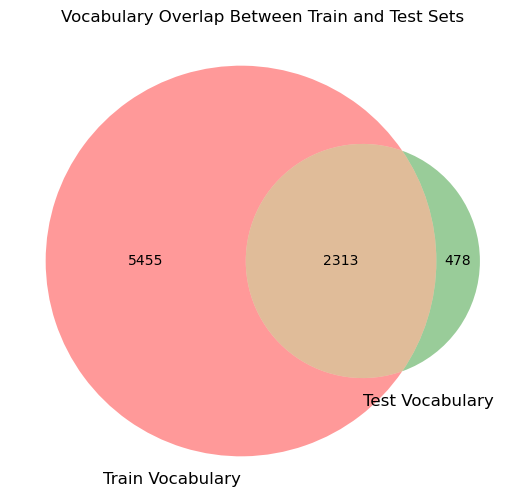

Train vocabulary size: 7768
Test vocabulary size: 2791
Vocabulary overlap: 2313 words (29.78% of train vocab)


In [50]:
overlap = len(train_vocab.intersection(test_vocab))
train_only = len(train_vocab - test_vocab)
test_only = len(test_vocab - train_vocab)

plt.figure(figsize=(10, 6))

venn2(subsets=(train_only, test_only, overlap), 
      set_labels=('Train Vocabulary', 'Test Vocabulary'))
plt.title('Vocabulary Overlap Between Train and Test Sets')
plt.savefig('vocab_overlap.png')
plt.show()
plt.close()

print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")
print(f"Vocabulary overlap: {overlap} words ({overlap/len(train_vocab)*100:.2f}% of train vocab)")

# Preprocessing

As per the project requirements we need correct and justified decisions on: 
- Tokenization 
- Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
- Removal of unknown/other words 
- Format cleaning (e.g. html-extracted text) 
- Truncation 
- Feature selection 
- Input format: how is data passed to the model? 
- Label format: what should the model predict? 
- Batching, padding 
- Vocabulary, embedding

We choose minimal preprocessing:
- We tokenize using NLTK's word tokenizer
- We preserve case, stopwords, and punctuation as they contain valuable information
- We skip stemming/lemmatization since our model (fasttext) handles word variations effectively
- No unknown word removal needed as fasttext creates vectors from character substrings
- No truncation required since all questions are under 400 characters
- No format cleaning needed as the dataset is already clean

To mention some examples, my preprocess function just performs simple tokenization preserving case, punctuation and all words including stopwords. I choose this approach because:
  - Case preservation: Words like 'I' or 'US' retain their semantic meaning
  - Stopword retention: Function words provide grammatical context important for question answering
  - Punctuation preservation: Punctuation can carry meaningful information
  - No stemming/lemmatization: Fasttext can handle morphological variations through subword embeddings
  - No unknown word removal: Fasttext creates vectors from character n-grams, allowing it to handle OOV words and misspellings

In [51]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string, got {0} instead".format(type(text).__name__))
    
    if not text or text.isspace():
        raise ValueError("Input text cannot be empty or whitespace only")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt')
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK punkt tokenizer: {str(e)}")

    try:
        tokens = word_tokenize(text)
        
        if len(tokens) == 0 and len(text.strip()) > 0:
            raise RuntimeError("Tokenization produced no tokens for non-empty input")
            
        return tokens
        
    except Exception as e:
        raise RuntimeError(f"Tokenization failed: {str(e)}")

To get a better understanding we check how the loaded embeddings look and how big the vocabulary is.

In [52]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print("\nFirst 10 words in vocabulary:")
print(wv.index_to_key[:10])

print("\nLast 5 words in vocabulary:")
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000

First 10 words in vocabulary:
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']

Last 5 words in vocabulary:
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Further we analyse how the vectors of different words look like

In [53]:
#print vector of word that should exist
print(wv["if"])

#print vector of word that should not exist
print(wv["apdnbajknbäaperoanböajnbäpad"])

[ 7.05022831e-03 -2.72363335e-01  3.08294799e-02 -6.69213533e-02
 -2.38569006e-01 -6.97940290e-02 -1.78919464e-01 -1.30932003e-01
  1.95379898e-01 -1.02779709e-01  1.13138333e-01 -8.10120851e-02
 -2.31069531e-02  8.10398385e-02  4.11642976e-02  2.13612169e-01
  2.07227275e-01 -1.44993244e-02 -1.49006667e-02  3.30467045e-01
 -8.75898227e-02  2.77748536e-02  1.65837809e-01 -2.82677233e-01
 -2.31202438e-01 -6.97928965e-02 -9.50594172e-02  1.27312019e-01
  8.41282010e-02  3.78092974e-01  8.13675299e-02 -4.12413254e-02
  3.80182602e-02 -8.93339440e-02 -6.99183196e-02  1.94707839e-03
  2.10201159e-01 -1.43054217e-01 -5.38324825e-02  5.93089908e-02
 -3.86625379e-02  6.96267113e-02 -2.00814441e-01  5.09383306e-02
  1.98449627e-01 -3.92922424e-02  5.64378798e-02  3.31560552e-01
  7.08746612e-02 -3.91262211e-02 -8.44963491e-02 -3.65556516e-02
  9.49307606e-02 -2.95668654e-02 -7.00519904e-02 -2.10410550e-01
 -1.39795244e-01  1.62995517e-01 -1.53789535e-01 -8.67058709e-02
 -7.03049498e-03 -2.27405

# Model

# Training

# Evaluation

# Interpretation